In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 14.3588 - acc: 0.1067
Epoch 00001: val_loss improved from inf to 14.36688, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_3_conv_checkpoint/001-14.3669.hdf5
36805/36805 [==============================] - 153s 4ms/sample - loss: 14.3590 - acc: 0.1067 - val_loss: 14.3669 - val_acc: 0.1083
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 14.1034 - acc: 0.1242
Epoch 00002: val_loss did not improve from 14.36688
36805/36805 [==============================] - 146s 4ms/sample - loss: 14.1032 - acc: 0.1242 - val_loss: 14.4339 - val_acc: 0.1039
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 14.0179 - acc: 0.1299
Epoch 00003: val_loss improved from 14.36688 to 13.89631, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_3_conv_che

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7451 - acc: 0.1471
Epoch 00028: val_loss improved from 13.77528 to 13.75852, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_3_conv_checkpoint/028-13.7585.hdf5
36805/36805 [==============================] - 147s 4ms/sample - loss: 13.7454 - acc: 0.1471 - val_loss: 13.7585 - val_acc: 0.1463
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7408 - acc: 0.1474
Epoch 00029: val_loss did not improve from 13.75852
36805/36805 [==============================] - 146s 4ms/sample - loss: 13.7407 - acc: 0.1474 - val_loss: 13.8620 - val_acc: 0.1398
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7882 - acc: 0.1445
Epoch 00030: val_loss did not improve from 13.75852
36805/36805 [==============================] - 145s 4ms/sample - loss: 13.7885 - acc: 0.1445 - val_loss: 13.8480 - val_acc: 0.1405
Epoch 31/500
36800/36805 [===================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7019 - acc: 0.1498
Epoch 00056: val_loss did not improve from 13.72548
36805/36805 [==============================] - 147s 4ms/sample - loss: 13.7018 - acc: 0.1498 - val_loss: 13.7560 - val_acc: 0.1465
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7179 - acc: 0.1488
Epoch 00057: val_loss did not improve from 13.72548
36805/36805 [==============================] - 146s 4ms/sample - loss: 13.7182 - acc: 0.1488 - val_loss: 13.7317 - val_acc: 0.1479
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7978 - acc: 0.1439
Epoch 00058: val_loss did not improve from 13.72548
36805/36805 [==============================] - 147s 4ms/sample - loss: 13.7977 - acc: 0.1439 - val_loss: 13.7766 - val_acc: 0.1451
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7193 - acc: 0.1487
Epoch 00059: val_loss did not improve from 13.72548
36805/3

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6976 - acc: 0.1501
Epoch 00085: val_loss did not improve from 13.70770
36805/36805 [==============================] - 146s 4ms/sample - loss: 13.6971 - acc: 0.1501 - val_loss: 13.7715 - val_acc: 0.1454
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7363 - acc: 0.1477
Epoch 00086: val_loss did not improve from 13.70770
36805/36805 [==============================] - 147s 4ms/sample - loss: 13.7366 - acc: 0.1477 - val_loss: 13.7882 - val_acc: 0.1444
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6932 - acc: 0.1503
Epoch 00087: val_loss did not improve from 13.70770
36805/36805 [==============================] - 146s 4ms/sample - loss: 13.6927 - acc: 0.1504 - val_loss: 13.7864 - val_acc: 0.1447
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6844 - acc: 0.1509
Epoch 00088: val_loss did not improve from 13.70770
36805/3

36800/36805 [============================>.] - ETA: 0s - loss: 13.7004 - acc: 0.1499
Epoch 00113: val_loss did not improve from 13.65947
36805/36805 [==============================] - 145s 4ms/sample - loss: 13.7007 - acc: 0.1499 - val_loss: 13.7715 - val_acc: 0.1456
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7355 - acc: 0.1477
Epoch 00114: val_loss did not improve from 13.65947
36805/36805 [==============================] - 146s 4ms/sample - loss: 13.7358 - acc: 0.1477 - val_loss: 13.8391 - val_acc: 0.1414
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.7486 - acc: 0.1469
Epoch 00115: val_loss did not improve from 13.65947
36805/36805 [==============================] - 147s 4ms/sample - loss: 13.7490 - acc: 0.1469 - val_loss: 13.7640 - val_acc: 0.1461
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6889 - acc: 0.1507
Epoch 00116: val_loss did not improve from 13.65947
36805/36805 [====

36800/36805 [============================>.] - ETA: 0s - loss: 13.6128 - acc: 0.1554
Epoch 00142: val_loss did not improve from 13.65947
36805/36805 [==============================] - 146s 4ms/sample - loss: 13.6131 - acc: 0.1554 - val_loss: 13.6867 - val_acc: 0.1507
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6170 - acc: 0.1552
Epoch 00143: val_loss did not improve from 13.65947
36805/36805 [==============================] - 147s 4ms/sample - loss: 13.6169 - acc: 0.1552 - val_loss: 13.6764 - val_acc: 0.1514
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6211 - acc: 0.1549
Epoch 00144: val_loss did not improve from 13.65947
36805/36805 [==============================] - 148s 4ms/sample - loss: 13.6210 - acc: 0.1549 - val_loss: 13.7086 - val_acc: 0.1493
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6361 - acc: 0.1539
Epoch 00145: val_loss did not improve from 13.65947
36805/36805 [====

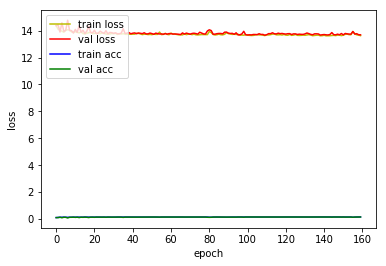

4815/4815 [==============================] - 9s 2ms/sample - loss: 13.6140 - acc: 0.1553
Loss: 13.613969903274489 Accuracy: 0.15534787

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 14.0240 - acc: 0.1262
Epoch 00001: val_loss improved from inf to 14.64002, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_4_conv_checkpoint/001-14.6400.hdf5
36805/36805 [==============================] - 159s 4ms/sample - loss: 14.0243 - acc: 0.1262 - val_loss: 14.6400 - val_acc: 0.0899
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.8656 - acc: 0.1890
Epoch 00002: val_loss improved from 14.64002 to 12.60628, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_4_conv_checkpoint/002-12.6063.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 12.8660 - acc: 0.1890 - val_loss: 12.6063 - val_acc: 0.1975
Epoch 3/500
36800/36805 [===========

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9862
Epoch 00028: val_loss did not improve from 0.77932
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0498 - acc: 0.9862 - val_loss: 1.1398 - val_acc: 0.7813
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9888
Epoch 00029: val_loss did not improve from 0.77932
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0437 - acc: 0.9888 - val_loss: 1.2037 - val_acc: 0.7838
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9879
Epoch 00030: val_loss did not improve from 0.77932
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0443 - acc: 0.9879 - val_loss: 1.2163 - val_acc: 0.7843
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9882
Epoch 00031: val_loss did not improve from 0.77932
36805/36805 [========

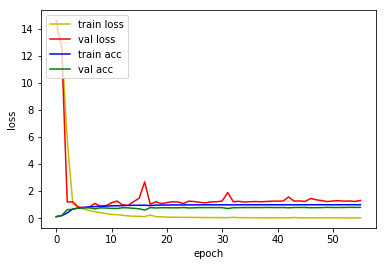

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.8486 - acc: 0.7362
Loss: 0.8485809605193411 Accuracy: 0.7362409

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.6992 - acc: 0.1434
Epoch 00001: val_loss improved from inf to 13.42317, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_5_conv_checkpoint/001-13.4232.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 13.6990 - acc: 0.1434 - val_loss: 13.4232 - val_acc: 0.1642
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.3680 - acc: 0.1668
Epoch 00002: val_loss did not improve from 13.42317
36805/36805 [==============================] - 162s 4ms/sample - loss: 13.3683 - acc: 0.1668 - val_loss: 13.8444 - val_acc: 0.1391
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.0219 - acc: 0.1863
Epoch 00003: val_loss improved from 13.42317 to 13.14

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0932 - acc: 0.9724
Epoch 00026: val_loss did not improve from 0.55778
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.0934 - acc: 0.9723 - val_loss: 0.6588 - val_acc: 0.8537
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0746 - acc: 0.9782
Epoch 00027: val_loss did not improve from 0.55778
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.0746 - acc: 0.9782 - val_loss: 0.6601 - val_acc: 0.8551
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9843
Epoch 00028: val_loss did not improve from 0.55778
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0539 - acc: 0.9843 - val_loss: 0.6547 - val_acc: 0.8644
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9891
Epoch 00029: val_loss did not improve from 0.55778
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9977
Epoch 00056: val_loss did not improve from 0.55778
36805/36805 [==============================] - 161s 4ms/sample - loss: 0.0121 - acc: 0.9977 - val_loss: 0.7458 - val_acc: 0.8658
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9977
Epoch 00057: val_loss did not improve from 0.55778
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0120 - acc: 0.9977 - val_loss: 0.7341 - val_acc: 0.8751
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9965
Epoch 00058: val_loss did not improve from 0.55778
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.0149 - acc: 0.9965 - val_loss: 0.7415 - val_acc: 0.8700
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9975
Epoch 00059: val_loss did not improve from 0.55778
36805/36805 [========

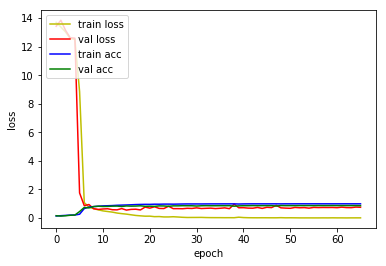

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.7109 - acc: 0.8093
Loss: 0.7108803769138372 Accuracy: 0.8093458

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6062 - acc: 0.4777
Epoch 00001: val_loss improved from inf to 0.98043, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_6_conv_checkpoint/001-0.9804.hdf5
36805/36805 [==============================] - 167s 5ms/sample - loss: 3.6058 - acc: 0.4777 - val_loss: 0.9804 - val_acc: 0.7072
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7773 - acc: 0.7720
Epoch 00002: val_loss did not improve from 0.98043
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.7776 - acc: 0.7720 - val_loss: 2.2823 - val_acc: 0.5076
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6051 - acc: 0.8218
Epoch 00003: val_loss improved from 0.98043 to 0.86832, saving 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9835
Epoch 00027: val_loss did not improve from 0.27519
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0560 - acc: 0.9835 - val_loss: 0.3134 - val_acc: 0.9317
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9897
Epoch 00028: val_loss did not improve from 0.27519
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0366 - acc: 0.9897 - val_loss: 0.2929 - val_acc: 0.9378
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9915
Epoch 00029: val_loss did not improve from 0.27519
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0306 - acc: 0.9915 - val_loss: 0.3076 - val_acc: 0.9359
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9917
Epoch 00030: val_loss did not improve from 0.27519
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.27519
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0111 - acc: 0.9974 - val_loss: 0.3259 - val_acc: 0.9399
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9982
Epoch 00058: val_loss did not improve from 0.27519
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0089 - acc: 0.9982 - val_loss: 0.3471 - val_acc: 0.9411
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9986
Epoch 00059: val_loss did not improve from 0.27519
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0071 - acc: 0.9986 - val_loss: 0.3491 - val_acc: 0.9404
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9981
Epoch 00060: val_loss did not improve from 0.27519
36805/36805 [========

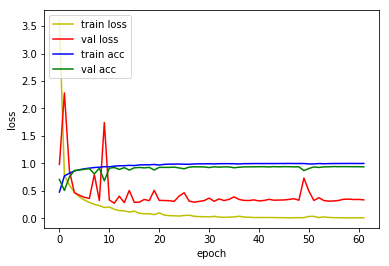

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3453 - acc: 0.9061
Loss: 0.34529382100605394 Accuracy: 0.9061267

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3245 - acc: 0.6323
Epoch 00001: val_loss improved from inf to 1.12809, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_7_conv_checkpoint/001-1.1281.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 1.3247 - acc: 0.6323 - val_loss: 1.1281 - val_acc: 0.6983
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5213 - acc: 0.8426
Epoch 00002: val_loss improved from 1.12809 to 0.64607, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_7_conv_checkpoint/002-0.6461.hdf5
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.5213 - acc: 0.8426 - val_loss: 0.6461 - val_acc: 0.7959
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9850
Epoch 00027: val_loss did not improve from 0.17383
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0487 - acc: 0.9850 - val_loss: 0.1876 - val_acc: 0.9550
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9921
Epoch 00028: val_loss did not improve from 0.17383
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0262 - acc: 0.9921 - val_loss: 0.2769 - val_acc: 0.9387
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9893
Epoch 00029: val_loss did not improve from 0.17383
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0364 - acc: 0.9892 - val_loss: 0.8591 - val_acc: 0.8085
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9837
Epoch 00030: val_loss improved from 0.17383 to 0.16945, saving model to model/checkpo

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9984
Epoch 00056: val_loss did not improve from 0.16760
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0069 - acc: 0.9984 - val_loss: 0.1770 - val_acc: 0.9653
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9989
Epoch 00057: val_loss did not improve from 0.16760
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0047 - acc: 0.9989 - val_loss: 0.5108 - val_acc: 0.9073
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9903
Epoch 00058: val_loss did not improve from 0.16760
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0307 - acc: 0.9902 - val_loss: 0.2405 - val_acc: 0.9527
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9914
Epoch 00059: val_loss did not improve from 0.16760
36805/36805 [========

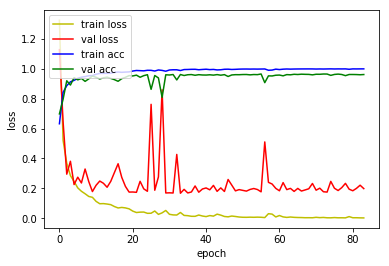

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1878 - acc: 0.9506
Loss: 0.18781093235822977 Accuracy: 0.9505711

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9969 - acc: 0.6928
Epoch 00001: val_loss improved from inf to 0.60705, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_8_conv_checkpoint/001-0.6070.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 0.9971 - acc: 0.6928 - val_loss: 0.6070 - val_acc: 0.8183
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3827 - acc: 0.8808
Epoch 00002: val_loss did not improve from 0.60705
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.3828 - acc: 0.8808 - val_loss: 1.7125 - val_acc: 0.6513
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2773 - acc: 0.9122
Epoch 00003: val_loss improved from 0.60705 to 0.39889, savin

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9933
Epoch 00027: val_loss did not improve from 0.11088
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0235 - acc: 0.9932 - val_loss: 0.4301 - val_acc: 0.9189
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9859
Epoch 00028: val_loss did not improve from 0.11088
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0431 - acc: 0.9859 - val_loss: 0.1386 - val_acc: 0.9653
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9916
Epoch 00029: val_loss did not improve from 0.11088
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0281 - acc: 0.9916 - val_loss: 0.1337 - val_acc: 0.9679
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9942
Epoch 00030: val_loss did not improve from 0.11088
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9883
Epoch 00056: val_loss did not improve from 0.09888
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0374 - acc: 0.9883 - val_loss: 0.1272 - val_acc: 0.9725
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9964
Epoch 00057: val_loss did not improve from 0.09888
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0116 - acc: 0.9964 - val_loss: 0.1843 - val_acc: 0.9653
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.09888
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0151 - acc: 0.9954 - val_loss: 0.1491 - val_acc: 0.9641
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9964
Epoch 00059: val_loss did not improve from 0.09888
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9993
Epoch 00086: val_loss did not improve from 0.09888
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0027 - acc: 0.9993 - val_loss: 0.1247 - val_acc: 0.9739
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9986
Epoch 00087: val_loss did not improve from 0.09888
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0049 - acc: 0.9986 - val_loss: 0.1234 - val_acc: 0.9741
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9992
Epoch 00088: val_loss did not improve from 0.09888
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0029 - acc: 0.9992 - val_loss: 0.1492 - val_acc: 0.9713
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9973
Epoch 00089: val_loss did not improve from 0.09888
36805/36805 [========

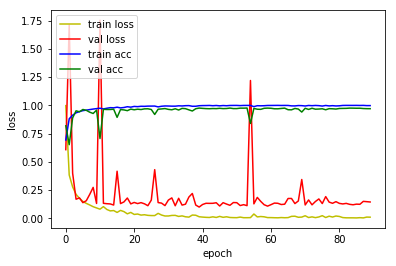

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1449 - acc: 0.9664
Loss: 0.14492283910435555 Accuracy: 0.96635514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8880 - acc: 0.7277
Epoch 00001: val_loss improved from inf to 0.51616, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_9_conv_checkpoint/001-0.5162.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.8881 - acc: 0.7277 - val_loss: 0.5162 - val_acc: 0.8367
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3179 - acc: 0.9010
Epoch 00002: val_loss did not improve from 0.51616
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.3180 - acc: 0.9009 - val_loss: 0.5763 - val_acc: 0.8227
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2296 - acc: 0.9275
Epoch 00003: val_loss improved from 0.51616 to 0.19759, savi

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9978
Epoch 00028: val_loss did not improve from 0.10371
36805/36805 [==============================] - 176s 5ms/sample - loss: 0.0096 - acc: 0.9978 - val_loss: 0.2023 - val_acc: 0.9618
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9917
Epoch 00029: val_loss did not improve from 0.10371
36805/36805 [==============================] - 176s 5ms/sample - loss: 0.0290 - acc: 0.9917 - val_loss: 0.1092 - val_acc: 0.9725
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9973
Epoch 00030: val_loss did not improve from 0.10371
36805/36805 [==============================] - 176s 5ms/sample - loss: 0.0104 - acc: 0.9973 - val_loss: 0.1149 - val_acc: 0.9727
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9975
Epoch 00031: val_loss did not improve from 0.10371
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9996
Epoch 00058: val_loss did not improve from 0.10371
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0017 - acc: 0.9996 - val_loss: 0.1146 - val_acc: 0.9760
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9997
Epoch 00059: val_loss did not improve from 0.10371
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0016 - acc: 0.9997 - val_loss: 0.1236 - val_acc: 0.9732
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9977
Epoch 00060: val_loss did not improve from 0.10371
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0083 - acc: 0.9977 - val_loss: 0.1238 - val_acc: 0.9765
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9993
Epoch 00061: val_loss did not improve from 0.10371
36805/36805 [========

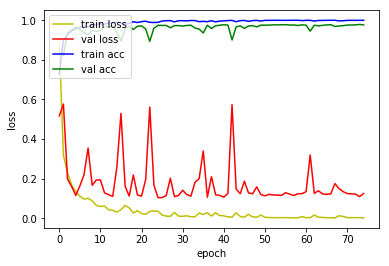

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1419 - acc: 0.9618
Loss: 0.14189552459569632 Accuracy: 0.9617861



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_025_DO_BN_SGD'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
                  metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_025_DO_BN_SGD'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           3805712     lambda[0][0]                     
                                                         

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1878 - acc: 0.9506
Loss: 0.18781093235822977 Accuracy: 0.9505711

1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequen

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           3805712     lambda[0][0]                     
                                                         

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2093 - acc: 0.9570
Loss: 0.20933819176693982 Accuracy: 0.9570094

1D_CNN_custom_ch_128_DO_025_DO_BN_SGD_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequen